# NMR Processing Overview

---

1. Split files into different categories.
    1. How many individual fids?
    2. How many array experiments?
    3. How are temperature sets stored?
    4. How are materials stored?
2. Develop / confirm metadata for those categories.
    + Cross reference with documentation provided by Trent.
    + Compare processing demo results to Trent's data. 
    + Meet with Trent to confirm assignments.
3. Prioritize subsets.
3. **Design Bokeh application**
4. Process subsets.

In [1]:
%load_ext autoreload
%autoreload 2

#### Set Local Data Path

---

Since the total available data is around 2 gb it may be stored in different locations on different machines. Define a base path to the data to simplify this.

In [2]:
data_folder = '/home/tylerbiggs/data/Sep-2016-23Na'
processed_data = "/home/tylerbiggs/data/processed_nmr"
# data_folder = '/home/tyler/data/Sep-2016-23Na'
# processed_data = "/home/tyler/data/processed_nmr"

In [3]:
import nmrglue as ng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import multiprocessing as mp
import glob
import re
import os
from tqdm import tqdm
%matplotlib inline

In [4]:
from trentnmr import *

# File Structure

---

From `tree -I *.fid` to find all non-fid directories.

```bash
└── Sep-2016-23Na
    ├── 23Na
    │   └── 27Al
    │       ├── 0808G1-0p15M-AlOH3-3M-NaOH-D2O
    │       ├── 0808G1-0p5M-AlOH3-3M-NaOH-D2O
    │       ├── 0808G1-1M-AlOH3-3M-NaOH-D2O
    │       ├── 0819G1-0p1M-AlOH3-3M-LiOH-D2O
    │       ├── 0819G1-0p5M-AlOH3-3M-KOH-D2O
    │       ├── 0819G1-0p5M-AlOH3-3M-LiOH-D2O
    │       ├── 0819G1-1M-AlOH3-3M-NaOH-D2O
    │       ├── background
    │       └── standard
    └── VT

```

Which seems like and error. Re-ordering to:

```bash
└── Sep-2016-23Na
    ├── 23Na
    ├── 27Al
    │   ├── 0808G1-0p15M-AlOH3-3M-NaOH-D2O
    │   ├── 0808G1-0p5M-AlOH3-3M-NaOH-D2O
    │   ├── 0808G1-1M-AlOH3-3M-NaOH-D2O
    │   ├── 0819G1-0p1M-AlOH3-3M-LiOH-D2O
    │   ├── 0819G1-0p5M-AlOH3-3M-KOH-D2O
    │   ├── 0819G1-0p5M-AlOH3-3M-LiOH-D2O
    │   ├── 0819G1-1M-AlOH3-3M-NaOH-D2O
    │   ├── background
    │   └── standard
    └── VT

```

## Glob Parent Folders

---

In [5]:
# Sodium folders.
VT   = os.path.join(data_folder, 'VT')
Na23 = os.path.join(data_folder, '23Na')

# Aluminum folders.
Al27 = os.path.join(data_folder, '27Al')
# Aluminum sub-paths.
sub_paths_strings = [
    "0808G1-0p15M-AlOH3-3M-NaOH-D2O",
    "0808G1-0p5M-AlOH3-3M-NaOH-D2O",
    "0808G1-1M-AlOH3-3M-NaOH-D2O",
    "0819G1-0p1M-AlOH3-3M-LiOH-D2O",
    "0819G1-0p5M-AlOH3-3M-KOH-D2O",
    "0819G1-0p5M-AlOH3-3M-LiOH-D2O",
    "0819G1-1M-AlOH3-3M-NaOH-D2O",
    "background",
    "standard"
]

Al_sub_paths = [os.path.join(Al27, p) for p in sub_paths_strings]

In [6]:
Al_sub_paths.append(Al27)
sodium_paths = [VT, Na23]

## Glob Helper Functions

---

In [7]:
array_glob = '/*arrays*.fid'
mis_arrays = '/*arryas*.fid'
fid_glob = '/*.fid'
special_files = ['reference', 'REF', 'calibration', 'pwX90', 'static',
                 'spin-up', 'without-liquid']

def nmr_glob(path):
    arrays = {fn for fn in glob.iglob(path + array_glob, recursive=False)}
    other_arrays = {fn for fn in glob.iglob(path + mis_arrays, recursive=False)}
    arrays = arrays | other_arrays
    
    fids = {fn for fn in glob.iglob(path + fid_glob, recursive=False)}
    
    other_fids = set()
    for f in fids:
        if any(sf in f for sf in special_files):
            other_fids.add(f)

    fids = fids - other_fids - arrays
            
    return [list(x) for x in [arrays, fids, other_fids]]


def process_group(path_list):
    array, fid, other = list(), list(), list()
    for path in path_list:
        a, f, o = nmr_glob(path)
        if a: array.append(a)
        if f: fid.append(f)        
        if o: other.append(o)
        
    return [list(itertools.chain.from_iterable(x)) for x in [array, fid, other]]

## Running the Globs

---

In [8]:
al_array, al_fid, al_other = process_group(Al_sub_paths)
na_array, na_fid, na_other = process_group(sodium_paths)

In [9]:
print(f'Normal Al fids: {len(al_fid)}')
print(f'Other Al fids:  {len(al_other)}')
print(f'Al Arrays:      {len(al_array)}')
print('-------------------------------')
print(f'Normal Na fids: {len(na_fid)}')
print(f'Other Na fids:  {len(na_other)}')
print(f'Na Arrays:      {len(na_array)}')

Normal Al fids: 139
Other Al fids:  15
Al Arrays:      88
-------------------------------
Normal Na fids: 49
Other Na fids:  9
Na Arrays:      1


# Processing the .fid Files

---

### Convert to NMRPipe files

Combine the arrays and the fids into two groups.

In [10]:
fids = set(al_fid) | set(al_other) | set(na_fid) | set(na_other)

In [11]:
Al_pipe_list = batch_nmrpipe_write(fids, processed_data)

100%|██████████| 212/212 [00:01<00:00, 120.48it/s]


### Process NMR Pipe Files

Takes a few minutes...

In [12]:
pipe_fids = pool_nmr_proc(Al_pipe_list, processed_data)

Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 42716392006.625854
         Current function value: 34339596288007.277344
         Iterations: 128
         Function evaluations: 259
         Iterations: 138
         Function evaluations: 276
Optimization terminated successfully.
         Current function value: 8.483408
         Iterations: 131
         Function evaluations: 280
Optimization terminated successfully.
         Current function value: 8921374720009.123047
         Iterations: 97
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: 57776210444288008.000000
         Iterations: 51
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 96848953344009.281250
         Iterations: 124
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: 6.565652
         Iteration

In [41]:
def create_peak_df(pipe_fid_list, intensity=500000):
    df_list = list()
    for f in pipe_fid_list:
        dic, data = ng.pipe.read(f)
        try:
            peaks = {f: ng.analysis.peakpick.pick(data, intensity)}
            df = pd.DataFrame(peaks).melt()
            df[['raw_hz', 'peak_id', 'line_width', 'integral']] = df['value'].apply(pd.Series)
            df = df.drop(columns='value')
            df['file_path'] = df['variable'].apply(trim_file)
            df = df.drop(columns='variable')
            df_list.append(df)

        except Exception as e:
#             print(f, e)
            pass
    return pd.concat(df_list, ignore_index=True)

In [57]:
peak_df = create_peak_df(pipe_fids)
len(peak_df)

/home/tylerbiggs/anaconda3/envs/py36/lib/python3.6/site-packages/nmrglue/fileio/pipe.py:1477: UserWarning: (163840,)cannot be shaped into(4, 32768)
  warn(str(data.shape) + "cannot be shaped into" + str(shape))


40576

In [58]:
peak_df.head()

,raw_hz,peak_id,line_width,integral,file_path
0,33324.0,1.0,0.000000,5.024905e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...
1,33328.0,2.0,0.000000,5.608260e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...
2,33331.0,3.0,1.000000,1.312852e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...
3,33389.0,4.0,10.205559,2.396010e+09,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...
4,33421.0,5.0,1.000000,1.853518e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...


## Extract Data from the Filenames

Building the metadata...

---

In [59]:
# Define the regex strings.
deg_C_regx = "([0-9]*)C"
all_hz_regx = "(\d*)Hz"
al_molarity_regx = "(\d*p*\d*)M-AlOH3"
li_molarity_regx = "(\d*p*\d*)M-LiOH"
na_molarity_regx = "(\d*p*\d*)M-NaOH"
alno3_molarity_regx = "(\d*p*\d*)M-AlNO3"
gibbsite_regx = "(\w*-*gibbsite|Gibbsite|boehmite|Boehmite)"
milli_gram_regx = "(\d*p\d*)mg"
count_regx = "(\d*)ct"
nmr_element = "(27Al|23Na)"

def process_peak_df(df):
    df['raw_Al_concentration'] = pd.to_numeric(df['file_path'].str.extract(al_molarity_regx).str.replace('p', '.'))
    df['raw_Li_concentration'] = pd.to_numeric(df['file_path'].str.extract(li_molarity_regx).str.replace('p', '.'))
    df['raw_Na_concentration'] = pd.to_numeric(df['file_path'].str.extract(na_molarity_regx).str.replace('p', '.'))
    df['raw_AlNO3_concentration'] = pd.to_numeric(df['file_path'].str.extract(alno3_molarity_regx).str.replace('p', '.'))
    
    df['degrees_celsius'] = df['file_path'].str.extract(deg_C_regx)
    df['Hz'] = df['file_path'].str.extract(all_hz_regx)
    df['Mat_Source'] = df['file_path'].str.extract(gibbsite_regx)
    df['raw_mg'] = df['file_path'].str.extract(milli_gram_regx).str.replace('p', '.')
    df['scan_count'] = df['file_path'].str.extract(count_regx)
    df['nmr_element'] = df['file_path'].str.extract(nmr_element)
    return

In [60]:
process_peak_df(peak_df)
peak_df.head()

/home/tylerbiggs/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/home/tylerbiggs/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app
/home/tylerbiggs/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
/home/tylerbiggs/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: Future

,raw_hz,peak_id,line_width,integral,file_path,raw_Al_concentration,raw_Li_concentration,raw_Na_concentration,raw_AlNO3_concentration,degrees_celsius,Hz,Mat_Source,raw_mg,scan_count,nmr_element
0,33324.0,1.0,0.000000,5.024905e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...,0.15,NaN,3.0,NaN,140,2660,NaN,NaN,32,23Na
1,33328.0,2.0,0.000000,5.608260e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...,0.15,NaN,3.0,NaN,140,2660,NaN,NaN,32,23Na
2,33331.0,3.0,1.000000,1.312852e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...,0.15,NaN,3.0,NaN,140,2660,NaN,NaN,32,23Na
3,33389.0,4.0,10.205559,2.396010e+09,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...,0.15,NaN,3.0,NaN,140,2660,NaN,NaN,32,23Na
4,33421.0,5.0,1.000000,1.853518e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/23Na-5th-2660Hz...,0.15,NaN,3.0,NaN,140,2660,NaN,NaN,32,23Na


In [62]:
peak_df[peak_df['raw_AlNO3_concentration'] == True]

,raw_hz,peak_id,line_width,integral,file_path,raw_Al_concentration,raw_Li_concentration,raw_Na_concentration,raw_AlNO3_concentration,degrees_celsius,Hz,Mat_Source,raw_mg,scan_count,nmr_element
753,16483.0,1.0,2.903129,1.045236e+08,27Al-1M-AlNO3-reference-09-02-2016-3pm.ft,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,27Al
754,16488.0,2.0,0.687178,2.776783e+06,27Al-1M-AlNO3-reference-09-02-2016-3pm.ft,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,27Al
755,16491.0,3.0,1.000000,1.606966e+06,27Al-1M-AlNO3-reference-09-02-2016-3pm.ft,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,27Al
756,16495.0,4.0,0.000000,6.641476e+05,27Al-1M-AlNO3-reference-09-02-2016-3pm.ft,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,27Al
757,16498.0,5.0,0.000000,5.696152e+05,27Al-1M-AlNO3-reference-09-02-2016-3pm.ft,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,27Al
37585,16483.0,1.0,15.202280,7.775336e+07,27Al-1M-AlNO3-reference-09-02-2016-10am.ft,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,27Al


In [61]:
peak_df.to_csv('all_nomral_fid_peaks.csv')

In [63]:
def calc_ppm(signal_freq, ref_freq=16483.0, instrument_freq=500e6):
    return (signal_freq - ref_freq) / instrument_freq * 10e6

In [70]:
peak_df = peak_df[peak_df['nmr_element'] == "27Al"]
peak_df['ppm'] = peak_df['raw_hz'].apply(calc_ppm)
peak_df

,raw_hz,peak_id,line_width,integral,file_path,raw_Al_concentration,raw_Li_concentration,raw_Na_concentration,raw_AlNO3_concentration,degrees_celsius,Hz,Mat_Source,raw_mg,scan_count,nmr_element,ppm
20,14225.0,1.0,0.000000,5.033340e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-45.16
21,14235.0,2.0,0.000000,5.292080e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-44.96
22,14590.0,3.0,0.000000,5.079750e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-37.86
23,14707.0,4.0,8.739629,7.358710e+09,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-35.52
24,15037.0,5.0,13.000000,7.916852e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-28.92
25,15040.0,6.0,0.000000,5.531898e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-28.86
26,15043.0,7.0,1.000000,1.159147e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-28.80
27,15049.0,8.0,0.000000,5.106322e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-28.68
28,15051.0,9.0,1.000000,1.157028e+06,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-28.64
29,15054.0,10.0,0.000000,5.225380e+05,0808G1-0p15M-AlOH3-3M-NaOH-D2O/27Al-concentrat...,0.15,NaN,3.0,NaN,50,2782,Gibbsite,NaN,128,27Al,-28.58


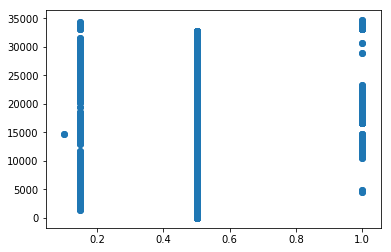

In [53]:
plt.scatter(x=peak_df['raw_Al_concentration'], y=peak_df['raw_hz'])

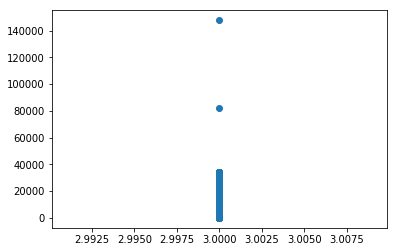

In [56]:
plt.scatter(x=peak_df['raw_Na_concentration'], y=peak_df['raw_hz'])